In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import random 
from scipy.special import comb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math 
from sklearn.preprocessing import StandardScaler



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
def load_data_from_csv(file_path):
    """
    从CSV文件中加载数据，并以NumPy数组的形式返回特征和标签。

    参数:
        file_path (str): CSV文件的路径。

    返回:
        X (np.ndarray): 特征数据数组。
        y (np.ndarray): 标签数组。
    """
    # 加载csv文件
    data = pd.read_csv(file_path)
    
    # 分离特征和标签
    if 'label' in data.columns:
        X = data.drop('label', axis=1).values  # 特征值
        y = data['label'].values  # 标签值
    else:
        X = data.values
        y = None

    return X, y

def visualize_data(X, y=None):
    """
    可视化数据点。如果数据维度大于2，使用PCA降维。

    参数:
        X (np.ndarray): 特征数据。
        y (np.ndarray): 标签数据，可为None。
    """
    
    # 如果 X 的特征大于2，我们需要进行降维
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 如果 X 的特征大于2，我们需要进行降维
    if X_scaled.shape[1] > 2:
        # 使用 PCA 将数据降至 2 维
        pca = PCA(n_components=2)
        X_reduced = pca.fit_transform(X_scaled)
    else:
        X_reduced = X_scaled

    # 绘制散点图，如果 y 非空，则根据不同的标签用不同颜色画出数据点
    if y is not None:
        plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=25, cmap='viridis')
        plt.legend()
    else:
        plt.scatter(X_reduced[:, 0], X_reduced[:, 1], s=25)

    plt.title("Data Visualization")
    plt.xlabel("Principal Component 1" if X_scaled.shape[1] > 2 else "Feature 1")
    plt.ylabel("Principal Component 2" if X_scaled.shape[1] > 2 else "Feature 2")
    plt.show()

from sklearn.datasets import load_iris

def load_iris_data():
    """
    加载 Iris 数据集，返回用于聚类的特征矩阵 X 和标签 y。

    返回:
        X (np.ndarray): 用于聚类的特征矩阵。
        y (np.ndarray): 数据集的标签。
    """
    # 加载 Iris 数据集
    iris = load_iris()
    X = iris.data  # 特征矩阵，用于聚类
    y = iris.target  # 标签

    return X, y

def load_spotify_data(genres_path):
    target_columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
    genres = pd.read_csv(genres_path)
    Xarray = []
    for col in target_columns:
        Xarray.append(genres[col].to_numpy()) 
    Xarray = np.stack(Xarray, axis=-1)
    name2label = {}
    label2name = {}
    labels = genres['genre'].unique()
    for i,l in enumerate(labels):
        name2label[l] = i 
        label2name[i] = l 
    genres['label']= genres['genre'].apply(lambda x : name2label[x])
    Yarray = genres['label'].to_numpy() 
    
    print(f"Loading Data: Xarray with shape {Xarray.shape}, Yarray with shape {Yarray.shape} ")
    return Xarray, Yarray

In [3]:
import numpy as np
import random

def initialize_kmeans_plusplus(X, k):
    """使用K-means++方法初始化中心"""
    n_samples, _ = X.shape
    centers = [X[random.randrange(n_samples)]]
    for _ in range(1, k):
        distances = np.array([min([np.inner(center-x, center-x) for center in centers]) for x in X])
        probs = distances / distances.sum()
        cumulative_probs = probs.cumsum()
        r = np.random.rand()
        for j, p in enumerate(cumulative_probs):
            if r < p:
                i = j
                break

        centers.append(X[i])

    return np.array(centers)
    

def initialize_centers(X,k,method = 'kmeans++' ):
    if method == 'kmeans++':
        return initialize_kmeans_plusplus(X,k)
    elif method == 'random':
        n_samples = X.shape[0]
        return X[random.sample(range(n_samples), k)] 
    else:
        raise ValueError(f"Unsupported initialization method: {method}")
        
def calculate_distance(x1, x2, method='euclidean'):
    """计算两点之间的距离，可以选择不同的方法"""
    if method == 'euclidean':
        return np.linalg.norm(x1 - x2)
    elif method == 'manhattan':
        return np.sum(np.abs(x1 - x2))
    elif method == 'cosine':
        return 1 - np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))
    else:
        raise ValueError(f"Unsupported distance method: {method}")

def kmeans(X, k, initialization='kmeans++', distance='euclidean', max_iters=100, tolerance=1e-4):
    """
    在数据上执行K-means聚类。

    参数:
        X (np.array): 数据点集合，大小为 [n_samples, n_features]
        k (int): 聚类的数量
        initialization (str): 初始化方法 ('random' or 'kmeans++')
        distance (str): 使用的距离度量 ('euclidean', 'manhattan', 'cosine')
        max_iters (int): 最大迭代次数
        tolerance (float): 判断收敛的容差

    返回:
        centers (np.array): 中心点的集合
        labels (list): 每个数据点的标签
    """
    # 初始化变量
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    n_samples, _ = X.shape
    centers = initialize_centers(X,k,initialization)
    labels = np.zeros(n_samples, dtype=int)
    is_converged = False

    # 迭代优化
    for _ in range(max_iters):
        # 为每个点分配最近的中心
        for i in range(n_samples):
            distances = [calculate_distance(X[i], center, method=distance) for center in centers]
            labels[i] = np.argmin(distances)

        # 计算新的中心
        new_centers = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        # 检查是否已经收敛
        center_shifts = np.array([calculate_distance(centers[i], new_centers[i], method=distance) for i in range(k)])
        if np.all(center_shifts <= tolerance):
            is_converged = True
            break

        centers = new_centers

    # 如果没有达到收敛
    if not is_converged:
        print("K-means did not converge. Consider increasing max_iters or check if the data is suitable for clustering.")

    return centers, labels

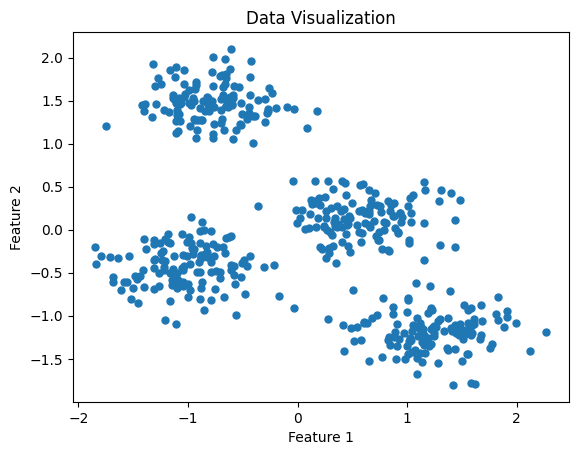

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


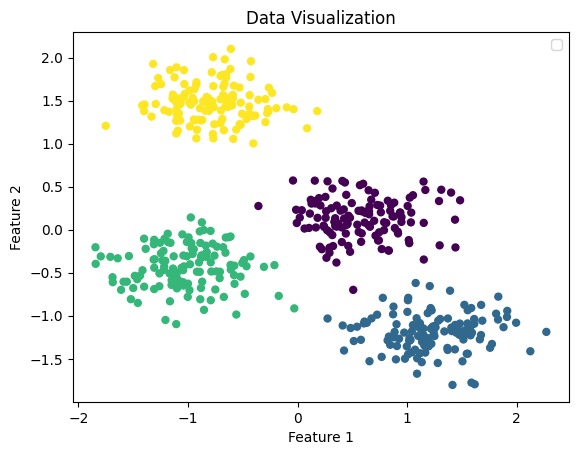

0.6833040440551403


In [11]:
x,y = load_data_from_csv("../blob_dataset.csv")
visualize_data(x)
centers, labels = kmeans(x,k = 4, initialization = 'kmeans++',distance='euclidean', max_iters = 500)
visualize_data(x,labels)

feature_columns = [f"Feature_{i}" for i in range(X.shape[1])]
data = pd.DataFrame(data=x, columns=feature_columns)
data['Cluster'] = labels
data.to_csv('./cluster_blob.csv', index=False)

from sklearn import metrics
silhouette_avg = metrics.silhouette_score(x, labels)
print(silhouette_avg)

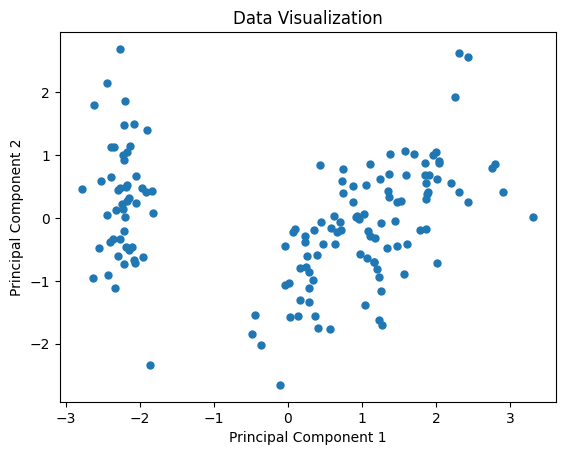

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


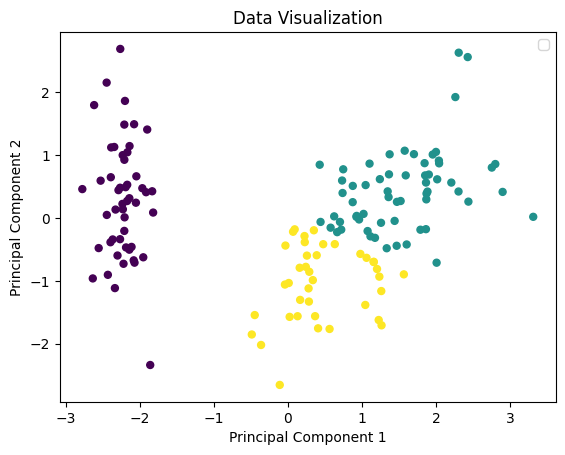

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


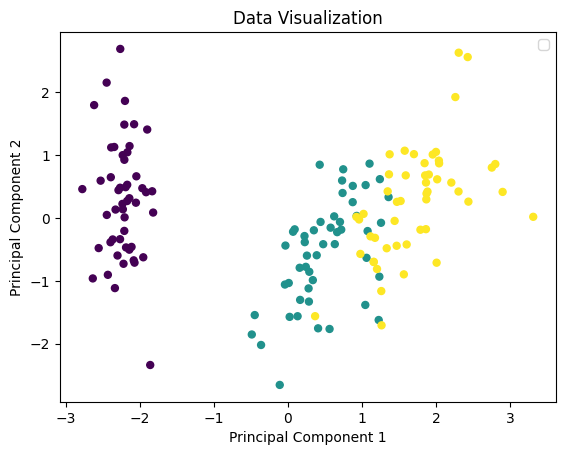

In [6]:
x,y = load_iris_data()
visualize_data(x)
centers, labels = kmeans(x,k = 3, initialization = 'kmeans++',distance='cosine', max_iters = 500)
visualize_data(x,labels)
visualize_data(x,y)

In [8]:
import heapq  # 用于实现优先队列（最小堆）

def build_adjacency_matrix(X, radius):
    """
    为数据点构建邻接矩阵，如果两点之间的距离小于指定的“半径”，则认为它们是相连的。
    """
    n_samples = X.shape[0]
    adjacency_matrix = np.zeros((n_samples, n_samples))

    for i in range(n_samples):
        for j in range(n_samples):
            dist = np.linalg.norm(X[i] - X[j])
            if dist < radius:
                # 这里，我们简单地使用“1”表示连接。实际情况下，可能会基于距离计算不同的连接权重。
                adjacency_matrix[i, j] = dist

    return adjacency_matrix

def graph_distance(adjacency_matrix, start, end):
    """
    使用 Dijkstra 算法计算图中两点之间的最短路径距离。
    """
    n_samples = adjacency_matrix.shape[0]
    distances = np.full(n_samples, np.inf)
    distances[start] = 0  # 起点到自身的距离是0
    pq = [(0, start)]  # 优先队列，包含（距离，顶点）对

    while pq:
        current_distance, current_vertex = heapq.heappop(pq)

        if current_vertex == end:
            return current_distance

        # 遍历与当前顶点相连的所有顶点
        for neighbor, weight in enumerate(adjacency_matrix[current_vertex]):
            if weight > 0:
                distance = current_distance + weight  # 对于这个简单的示例，权重即是边的长度
                # 如果找到了一条更短的路径，则更新最短距离
                if distance < distances[neighbor]:
                    distances[neighbor] = distance
                    heapq.heappush(pq, (distance, neighbor))

    return np.inf  # 如果没有路径连接两点，返回无穷大

In [9]:
def k_means_graph(X, n_clusters, adjacency_matrix, max_iter=100):
    """
    在使用图距离的情况下执行 K-means 聚类。

    参数:
        X (np.ndarray): 数据点。
        n_clusters (int): 聚类中心的数量。
        adjacency_matrix (np.ndarray): 数据点的邻接矩阵。
        max_iter (int): 最大迭代次数。

    返回:
        centroids (np.ndarray): 聚类中心。
        labels (np.ndarray): 每个数据点的标签。
    """
    n_samples = X.shape[0]

    # 随机初始化聚类中心
    initial_indices = np.random.choice(n_samples, n_clusters, replace=False)
    centroids = X[initial_indices]

    for _ in range(max_iter):
        labels = np.zeros(n_samples)

        # Step 1: 分配标签
        for i in range(n_samples):
            distances = [graph_distance(adjacency_matrix, i, j) for j in initial_indices]
            labels[i] = np.argmin(distances)

        # Step 2: 更新聚类中心
        new_centroids = np.zeros((n_clusters, X.shape[1]))
        for i in range(n_clusters):
            # 通过图距离找到属于同一聚类的点可能较为复杂和消耗计算资源，这里我们用传统方法。
            members = X[labels == i]
            new_centroids[i] = np.mean(members, axis=0)

        # 如果聚类中心没有变化，则终止
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return centroids, labels

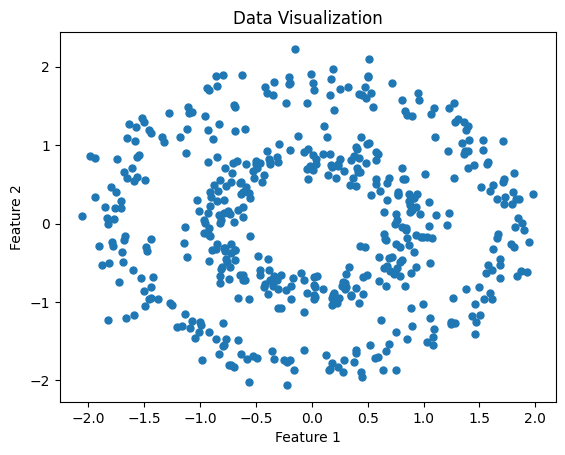

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


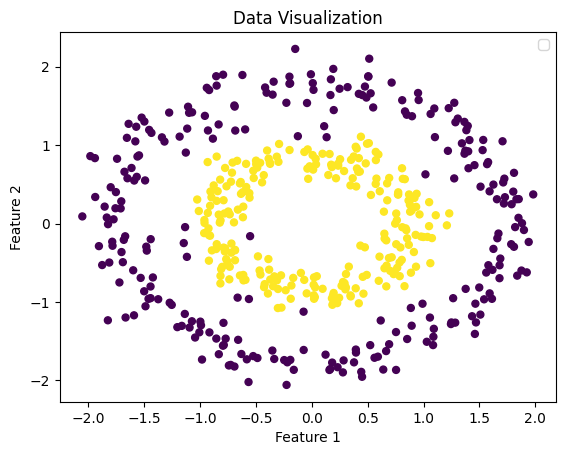

0.6833040440551403

In [12]:
X,y = load_data_from_csv("../circle_data.csv")
visualize_data(X)

# 假设我们有一个半径，基于这个半径我们可以构建邻接矩阵
radius = 0.1  # 这个值可能需要根据您的数据进行调整
adjacency_matrix = build_adjacency_matrix(X, radius)

# 假设我们想要的聚类数量
n_clusters = 2

# 执行 K-means 聚类
centroids, labels = k_means_graph(X, n_clusters, adjacency_matrix,max_iter=100)

feature_columns = [f"Feature_{i}" for i in range(X.shape[1])]
data = pd.DataFrame(data=X, columns=feature_columns)
data['Cluster'] = labels
data.to_csv('./cluster_cirlce.csv', index=False)


# 可视化聚类结果
visualize_data(X, labels)

0.6833040440551403